<center>
    <h1>Data Wrangling Project</h1>
    <h2>We Rate Dogs Twitter Archive</h2>
</center>

In [1]:
# Load required packages
import pandas as pd
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
from functools import partial
import random
import re
import numpy as np

Key Points
Key points to keep in mind when data wrangling for this project:
<ul>
    <li>You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.</li>
    <li>Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset..</li>
    <li>Cleaning includes merging individual pieces of data according to the rules of tidy data..</li>
    <li>The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs..</li>
    <li>You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used..</li>
</ul>

## Gather

We will gather information from We Rate Dogs tweets archived in the file "twitter-archive-enhanced.csv" -- stored locally; gather tweet image preditions from the file "image-predictions.tsv" programmatically from Udacity's servers; gather retweets and likes directly from twitter by interfacing with twitters API. 

### Importing the twitter archive from a csv file

In [2]:
# import WeRateDogs archive to pandas dataframe

archive_df = pd.read_csv('twitter-archive-enhanced.csv')

### Download "image-predictions.tsv" programmatically from Udacity's servers and read into a dataframe.

In [3]:
# location of file on the internet
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# get the contents of the file and write contents to a file locally named after the original file name from the server.
response = requests.get(url)
with open(url.split('/')[-1], mode = 'wb') as file :
    file.write(response.content)

# read the file into a dataframe.    
image_df = pd.read_csv('image-predictions.tsv', sep='\t')


### Download data from Twitter via Twitter API and save to 'tweet_json.txt' file

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))        
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start) 
print(fails_dict)

### Create new 'retweets_faves_df' dataframe to append retweets and favorites count from JSON file to.

In [4]:
# no line breaks exists in file. 
# Solution found at https://stackoverflow.com/questions/21708192/how-do-i-use-the-json-module-to-read-in-one-json-object-at-a-time/21709058#21709058]

def json_parse(fileobj, decoder=json.JSONDecoder(), buffersize=2048, 
               delimiters=None):
    remainder = ''
    for chunk in iter(partial(fileobj.read, buffersize), ''):
        remainder += chunk
        while remainder:
            try:
                stripped = remainder.strip(delimiters)
                result, index = decoder.raw_decode(stripped)
                yield result
                remainder = stripped[index:]
            except ValueError:
                # Not enough data to decode, read more
                break

In [5]:
# create new dataframe for retweet counts and favorite counts.
retweets_faves_df = pd.DataFrame(columns=['tweet_id','retweet_count','favorite_count'])


with open('tweet_json.txt','r') as file:
    for data in json_parse(file):
        retweets_faves_df = retweets_faves_df.append({'tweet_id':data['id'],'retweet_count':data['retweet_count'],'favorite_count':data['favorite_count']},ignore_index=True)        
        


In [6]:
# check if datafram for retweets and favorites was created
retweets_faves_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Assess

<ul>
    <li>Quality: issues with content. Low quality data is also known as dirty data.</li>
    <li>Tidiness: issues with structure that prevent easy analysis. Untidy data is also known as messy data.</li>
    Tidy data requirements:
    <ol>
        <li>Each variable forms a column.</li>
        <li>Each observation forms a row.</li>
        <li>Each type of observational unit forms a table.</li>
    </ol>
</ul>
<br>
...using two types of assessment:
<ul>
    <li>Visual assessment: scrolling through the data in your preferred software application (Google Sheets, Excel, a text editor, etc.).</li>
    <li>Programmatic assessment: using code to view specific portions and summaries of the data (pandas' head, tail, and info methods, for example).</li>
</ul>

In [7]:
# visual assessment of archive_df
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [8]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
archive_df[archive_df.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [10]:
# create list of tweets that have missing photos and should be excluded in final dataframe
missing_photos = []
for x in archive_df.tweet_id :
    if len(image_df[image_df.tweet_id == x])==0 :
        missing_photos.append(x)
len(missing_photos)

281

In [11]:
# select randomly from missing_photos list to see if it exists in the image_df dataframe. It should not exist.
image_df[image_df.tweet_id == random.choice(missing_photos)]


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [12]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
archive_df['name'].value_counts()

None         745
a             55
Charlie       12
Cooper        11
Lucy          11
Oliver        11
Lola          10
Tucker        10
Penny         10
Winston        9
Bo             9
the            8
Sadie          8
Bailey         7
Buddy          7
Toby           7
an             7
Daisy          7
Dave           6
Jack           6
Jax            6
Leo            6
Milo           6
Scout          6
Oscar          6
Bella          6
Stanley        6
Rusty          6
Koda           6
Chester        5
            ... 
Kawhi          1
Buddah         1
Sully          1
Gunner         1
Pancake        1
Binky          1
Kendall        1
Sailor         1
Naphaniel      1
Thor           1
Bobby          1
Banditt        1
Acro           1
Tupawc         1
Enchilada      1
Taz            1
Gilbert        1
Derby          1
Mollie         1
Tuck           1
Daniel         1
Duddles        1
Rolf           1
Marty          1
Noosh          1
Stefan         1
Perry          1
Benny         

In [14]:
# doggo                         2356 non-null object
# floofer                       2356 non-null object
# pupper                        2356 non-null object
# puppo                         2356 non-null object
print(archive_df.doggo.value_counts())
print(archive_df.floofer.value_counts())
print(archive_df.pupper.value_counts())
print(archive_df.puppo.value_counts())

w = archive_df.doggo.value_counts()[1]
x = archive_df.floofer.value_counts()[1]
y = archive_df.pupper.value_counts()[1]
z = archive_df.puppo.value_counts()[1]

print(w+x+y+z)

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64
394


In [15]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### Quality
#### archive_df table

* tweet_id, in_reply_to_status_id and in_reply_to_user_id are not string format
* timestamp is not datetime type.
* there are retweeted messages
* there are tweets that do not include photos
* some of the dogs' names are None
* some of the dogs' names are 'a'
* some of the dogs' names are 'an'
* some of the dogs' names are not capitalized
* name, doggo, floofer, pupper, and puppo variables have string value equal to 'None'
* missing dog stages can be found in the text variable

### Tidiness
* doggo, floofer, pupper, puppo can be one column


In [16]:
image_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [17]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Quality
#### image_df table

* tweet_id is not string

### Tidiness
#### image_df table

* dog breed predictions has multiple predictions where some are unreliable and unnecessary to keep.

In [18]:
retweets_faves_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [19]:
retweets_faves_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: object(3)
memory usage: 55.2+ KB


### Quality
#### retweets_faves_df table

* retweet_count and favorite_count are the wrong data type


## Final Assessment of All Datasets
### Quality
#### archive_df table

* tweet_id, in_reply_to_status_id and in_reply_to_user_id are not string format
* timestamp is not datetime type.
* there are retweeted messages
* there are tweets that do not include photos
* some of the dogs' names are None
* some of the dogs' names are 'a'
* some of the dogs' names are 'an'
* some of the dogs' names are not capitalized
* name, doggo, floofer, pupper, and puppo variables have string value equal to 'None'
* missing dog stages can be found in the text variable

#### image_df table

* tweet_id is not string

#### retweets_faves_df table

* retweet_count and favorite_count are the wrong data type

### Tidiness
#### archive_df table
* doggo, floofer, pupper, puppo can be one column

#### image_df table

* dog breed predictions has multiple predictions where some are unreliable and unnecessary to keep.

#### all tables
* multiple tables that have relevant information separate.

## Clean

I will create temporary dataframes for cleaning the data so I can make changes that I have a backup should the cleaning process damage or lose data.

In [20]:
archive_df_clean = archive_df.copy()
image_df_clean = image_df.copy()
retweets_faves_df_clean = retweets_faves_df.copy()

#### Define
#### Quality
##### archive_df table
* tweet_id, in_reply_to_status_id and in_reply_to_user_id are not string format
* timestamp is not datetime type

Use pd.to_datetime() to convert timestamp in archive_df_clean to datetime.

Use astype() to change tweet_id, in_reply_to_status_id and in_reply_to_user_id to string

#### Code

In [21]:
archive_df_clean.tweet_id = archive_df_clean.tweet_id.astype('str')
archive_df_clean.in_reply_to_status_id = archive_df_clean.in_reply_to_status_id.astype('str')
archive_df_clean.in_reply_to_user_id = archive_df_clean.in_reply_to_user_id.astype('str')

In [22]:
archive_df_clean.timestamp = pd.to_datetime(archive_df_clean.timestamp)

#### Test

In [23]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns

#### Define
#### Quality
##### archive_df table
* there are retweeted messages


Assign the restricted archive_df_clean dataframe excluding records with value in the retweeted_status_id back to archive_df_clean. 


#### Code

In [24]:
archive_df_clean = archive_df_clean[archive_df.retweeted_status_id.isnull()]

#### Test

In [25]:
# check there are any records with value in the retweeted_status_id variable. This should have no records
archive_df_clean[archive_df_clean.retweeted_status_id.notnull()]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [26]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         2175 non-null object
in_reply_to_user_id           2175 non-null object
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns](1), 

#### Define
#### Quality
#### image_df table
tweet_id is not string
##### archive_df table
* there are tweets that do not include photos
Assign the restricted archive_df_clean dataframe excluding records without a corresponding value in the image_df_clean dataframe based on tweet_id. Need to convert tweet_id in image_df first so we properly determine which records don't have images.

#### Code

In [27]:
image_df_clean.tweet_id = image_df_clean.tweet_id.astype('str')

In [28]:
missing_photos = []
for x in archive_df_clean.tweet_id :
    if len(image_df_clean[image_df_clean.tweet_id == x])==0 :
        missing_photos.append(x)


In [29]:
archive_df_clean = archive_df_clean[~archive_df_clean.tweet_id.isin(missing_photos)]

#### Test

In [30]:
# check tweet_id data type
image_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [31]:
# check if there are any tweets missing images
missing_photos = []
for x in archive_df_clean.tweet_id :
    if len(image_df_clean[image_df_clean.tweet_id == x])==0 :
        missing_photos.append(x)
len(missing_photos)

0

In [32]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null object
in_reply_to_status_id         1994 non-null object
in_reply_to_user_id           1994 non-null object
timestamp                     1994 non-null datetime64[ns]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
dtypes: datetime64[ns](1), 

In [33]:
image_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### Define
#### Quality
##### archive_df table
* some of the dogs' names are None
* some of the dogs' names are 'a'
* some of the dogs' names are 'an'
* some of the dogs' names are not capitalized

Use replace() with str.capitalize() to capitalize lowercase names

The extract the right name from the text where it is available where it begins with 'name is' and 'named'.

Set and remaining 'none', 'an' and 'a' to NaN.

#### Code

In [34]:
name_is_df = archive_df_clean.loc[archive_df_clean['text'].str.contains('name is')]
named_df = archive_df_clean.loc[archive_df_clean['text'].str.contains('named')]

In [35]:
# create list of names from dataframe that starts with 'name is'
name = []

for x in name_is_df.text :
    y = x.split('name is ',1)[1]
    name.append(y.partition(' ')[0])

# remove '.'
name = [i.replace('.', '') for i in name]

name_is_df['name_2'] = name

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [36]:
# create list of names from dataframe that starts with 'named'
name = []

for x in named_df.text :
    y = x.split('named ',1)[1]
    name.append(y.partition('.')[0])

named_df['name_2'] = name

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
# assign name from named_df to corresponding record in the archive_df dataframe
for x in named_df.index :
    archive_df_clean.loc[x, 'name'] = named_df.loc[x, 'name_2']



In [38]:
# assign name from name_is_df to corresponding record in the archive_df dataframe
for x in name_is_df.index :
    archive_df_clean.loc[x, 'name'] = name_is_df.loc[x, 'name_2']

In [39]:
# check if there are any dogs named 'a' which the word 'name' exists in the text variable.
pd.set_option('display.max_colwidth', -1)
archive_df_clean.loc[(archive_df_clean.name == 'a') & (archive_df_clean.text.str.contains('name') )]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [40]:
# visually check if name can be found in text column
pd.set_option('display.max_colwidth', -1)
archive_df_clean.loc[(archive_df_clean.name == 'a')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,nan,nan,2017-07-02 15:32:16,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None
649,792913359805018113,nan,nan,2016-10-31 02:17:31,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1",13,10,a,None,None,None,None
801,772581559778025472,nan,nan,2016-09-04 23:46:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1",10,10,a,None,None,None,None
1002,747885874273214464,nan,nan,2016-06-28 20:14:22,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/747885874273214464/photo/1,https://twitter.com/dog_rates/status/747885874273214464/photo/1",8,10,a,None,None,None,None
1004,747816857231626240,nan,nan,2016-06-28 15:40:07,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857231626240/photo/1,4,10,a,None,None,None,None
1017,746872823977771008,nan,nan,2016-06-26 01:08:52,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/746872823977771008/photo/1,https://twitter.com/dog_rates/status/746872823977771008/photo/1",11,10,a,None,None,None,None
1049,743222593470234624,nan,nan,2016-06-15 23:24:09,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593470234624/photo/1,12,10,a,None,None,pupper,None
1193,717537687239008257,nan,nan,2016-04-06 02:21:30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10 https://t.co/2ATDsgHD4n,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717537687239008257/photo/1,11,10,a,None,None,None,None
1207,715733265223708672,nan,nan,2016-04-01 02:51:22,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Th

Visually found a record where the name is in the text but not in the name variable.

index: 649 
name: Forrest 

In [41]:
# visually check if name can be found in text column
pd.set_option('display.max_colwidth', -1)
archive_df_clean.loc[(archive_df_clean.name == 'an')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1025,746369468511756288,nan,nan,2016-06-24 15:48:42,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746369468511756288/photo/1,9,10,an,None,None,None,None
1362,703041949650034688,nan,nan,2016-02-26 02:20:37,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703041949650034688/photo/1,10,10,an,None,None,None,None
2333,666337882303524864,nan,nan,2015-11-16 19:31:45,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an extremely rare horned Parthenon. Not amused. Wears shoes. Overall very nice. 9/10 would pet aggressively https://t.co/QpRjllzWAL,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666337882303524864/photo/1,9,10,an,None,None,None,None
2335,666287406224695296,nan,nan,2015-11-16 16:11:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,an,None,None,None,None
2349,666051853826850816,nan,nan,2015-11-16 00:35:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2,10,an,None,None,None,None


No name found in text

In [42]:
# update name variable based on the index discovered earlier. 
archive_df_clean.loc[649, 'name'] = 'Forrest'

In [43]:
# visually check if name can be found in text column
pd.set_option('display.max_colwidth', -1)
archive_df_clean.loc[(archive_df_clean.name == 'None')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,nan,nan,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
7,890729181411237888,nan,nan,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
12,889665388333682689,nan,nan,2017-07-25 01:55:32,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13,10,None,None,None,None,puppo
24,887343217045368832,nan,nan,2017-07-18 16:08:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217045368832/video/1,13,10,None,None,None,None,None
25,887101392804085760,nan,nan,2017-07-18 00:07:08,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392804085760/photo/1,12,10,None,None,None,None,None
37,885167619883638784,nan,nan,2017-07-12 16:03:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happenings. 13/10 https://t.co/44ItaMubBf,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/885167619883638784/photo/1,https://twitter.com/dog_rates/status/885167619883638784/photo/1,https://twitter.com/dog_rates/status/885167619883638784/photo/1,https://twitter.com/dog_rates/status/885167619883638784/photo/1",13,10,None,None,None,None,None
41,884441805382717440,nan,nan,2017-07-10 15:58:53,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805382717440/photo/1,14,10,None,None,None,None,None
47,883117836046086144,nan,nan,2017-07-07 00:17:54,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Please only send dogs. We don't rate mechanics, no matter how h*ckin good. Thank you... 13/10 would sneak a pat https://t.co/Se5fZ9wp5E",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883117836046086144/photo/1,https://twitter.com/dog_rates/status/883117836046086144/photo/1",13,10,None,None,None,None,None
59,880872448815771648,nan,nan,2017-06-30 19:35:32,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ugh not again. We only rate dogs. Please don't send in well-dressed floppy-tongued street penguins. Dogs only please. Thank you... 12/10 https://t.co/WiAMbTkDPf,NaN,NaN,NaN,htt

Visually found records where the name is in the text but not in the name variable.

* index = 157,  Boomer
* index = 177, Meeko
* index = 184, Charlie


In [44]:
# update name variable based on the indices discovered above. 
archive_df_clean.loc[157, 'name'] = 'Boomer'
archive_df_clean.loc[177, 'name'] = 'Meeko'
archive_df_clean.loc[184, 'name'] = 'Charlie'

Make sure all the names begin in uppercase

In [45]:
archive_df_clean.name = archive_df_clean.name.str.capitalize()

Change all name values that are 'None' and 'a' to NaN.

In [46]:
archive_df_clean.name = archive_df_clean.name.replace('None', np.nan)
archive_df_clean.name = archive_df_clean.name.replace('A', np.nan)
archive_df_clean.name = archive_df_clean.name.replace('An', np.nan)

#### Test

In [47]:
archive_df_clean.name.value_counts()

Charlie       12
Lucy          10
Cooper        10
Oliver        10
Penny         9 
Tucker        9 
Sadie         8 
Winston       8 
The           7 
Daisy         7 
Toby          7 
Lola          7 
Stanley       6 
Jax           6 
Koda          6 
Bo            6 
Bella         6 
Leo           5 
Rusty         5 
Bailey        5 
Buddy         5 
Oscar         5 
Scout         5 
Zoey          5 
Louis         5 
Milo          5 
Chester       5 
Dave          5 
Dexter        4 
Cassie        4 
             .. 
Barclay       1 
Farfle        1 
Finnegus      1 
Newt          1 
Stefan        1 
Noosh         1 
Marty         1 
Rolf          1 
Gordon        1 
Mabel         1 
Grey          1 
Bertson       1 
Vinscent      1 
Rocco         1 
Ebby          1 
Jarvis        1 
Bell          1 
Bobby         1 
Banditt       1 
Acro          1 
Tupawc        1 
Enchilada     1 
Gilbert       1 
Officially    1 
Naphaniel     1 
Mollie        1 
Daniel        1 
Duddles       

#### Define
#### Quality
##### archive_df table
* name, doggo, floofer, pupper, and puppo variables have string value equal to 'None'
* missing dog stages can be found in the text variable

#### Tidiness
##### archive_df table
* doggo, floofer, pupper, puppo can be one column

Use melt to combine to a single column called 'stage'.

Try to fill any missing data

#### Code

In [48]:
# define columns to keep and columns to melt
melt_cols = ['doggo', 'floofer', 'pupper', 'puppo']
keep_cols = [x for x in archive_df_clean.columns.tolist() if x not in melt_cols]

archive_df_clean = pd.melt(archive_df_clean, id_vars = keep_cols, value_vars = melt_cols, var_name = 'stages', value_name = 'stage')

# drop unnecessary new column
archive_df_clean = archive_df_clean.drop('stages', 1)

# drop duplicated records
archive_df_clean = archive_df_clean.sort_values('stage').drop_duplicates('tweet_id', keep = 'last')


I created tables that would find out if the words 'dog', 'floo', 'pup', 'puppo'. I decided to shorten 'doggo' to 'dog' because the instances that 'dog' is found in the text, it is safe to assume the dog is an adult. I shorted 'floofer' to 'floo' because there have been variations in the text 'floofer' but always starts with 'floo'. I decided to first assign anything that begins with 'pup' to 'pupper' first and then if anything is actually 'puppo', I would assign 'puppo' accordingling.

In [49]:
doggo = archive_df_clean.loc[archive_df_clean['text'].str.contains('dog')]
floofer = archive_df_clean.loc[archive_df_clean['text'].str.contains('floo')]
pupper = archive_df_clean.loc[archive_df_clean['text'].str.contains('pup')]
puppo = archive_df_clean.loc[archive_df_clean['text'].str.contains('puppo')]


In [50]:
# assign the stage based on the text variable to the stage variable

for i in doggo.index :
    archive_df_clean.loc[i, 'stage'] = 'doggo'

for i in floofer.index :
    archive_df_clean.loc[i, 'stage'] = 'floofer'

for i in pupper.index :
    archive_df_clean.loc[i, 'stage'] = 'pupper'
    
for i in puppo.index :
    archive_df_clean.loc[i, 'stage'] = 'puppo'

In [51]:
# Assign NaN to all 'None' values
archive_df_clean.stage = archive_df_clean.stage.replace('None', np.nan)


#### Test

In [52]:
print(archive_df_clean.stage.value_counts())
print(len(archive_df_clean))

pupper     451
doggo      329
floofer    29 
puppo      29 
Name: stage, dtype: int64
1994


In [53]:
# visually check if none can be found in stage column
pd.set_option('display.max_colwidth', -1)
archive_df_clean.loc[archive_df_clean.stage == 'None']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage


#### Define
#### Quality
##### retweets_faves_df table

* retweet_count and favorite_count are the wrong data type

Change all columns to INT. 

#### Code

In [54]:
retweets_faves_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: object(3)
memory usage: 55.2+ KB


In [55]:
# convert tweet_id to int then back to object
retweets_faves_df_clean.tweet_id = retweets_faves_df_clean.tweet_id.astype('int64')
retweets_faves_df_clean.tweet_id = retweets_faves_df_clean.tweet_id.astype('str')

# change datatype from object to int
retweets_faves_df_clean.retweet_count = retweets_faves_df_clean.retweet_count.astype('int64')
retweets_faves_df_clean.favorite_count = retweets_faves_df_clean.favorite_count.astype('int64')

The reason I had to convert the tweet_id variable from object to int then back to object is that I found that I could not merge on the variables as it is. I tried to remove any white spaces initially but I still could not match the tweet_id with the tweet_ids on other tables.

#### Test

In [56]:
retweets_faves_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


#### Define
#### Tidiness
##### image_df table

* dog breed predictions has multiple predictions where some are unreliable and unnecessary to keep.

Drop range of columns from "p1_dog" to "p3_dog" columns. If the "p1_dog" column is false, change p1 to NaN.

#### Code

In [57]:
# If the p1 dog prediction is not a dog breed, take from p2 or p3 if it exists

for i in image_df_clean.index :
    if image_df_clean.loc[i, 'p1_dog'] == False :
        if image_df_clean.loc[i, 'p2_dog'] == True :
            image_df_clean.loc[i, 'p1'] = image_df_clean.loc[i, 'p2']
            image_df_clean.loc[i, 'p1_conf'] = image_df_clean.loc[i, 'p2_conf']
            image_df_clean.loc[i, 'p1_dog'] = image_df_clean.loc[i, 'p2_dog']
        elif image_df_clean.loc[i, 'p3_dog'] == True :
            image_df_clean.loc[i, 'p1'] = image_df_clean.loc[i, 'p3']
            image_df_clean.loc[i, 'p1_conf'] = image_df_clean.loc[i, 'p3_conf']
            image_df_clean.loc[i, 'p1_dog'] = image_df_clean.loc[i, 'p3_dog']


In [58]:
# change p1 value to 'NaN' if the p1_dog value is FALSE
for i in image_df_clean.index :
    if image_df_clean.loc[i, 'p1_dog'] == False :
        image_df_clean.loc[i, 'p1'] = np.nan
        image_df_clean.loc[i, 'p1_conf'] = 0

In [59]:
# Check column names in the dataframe 
image_df_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [60]:
# drop the range of columns
image_df_clean = image_df_clean.drop(image_df_clean.columns.to_series()["p1_dog":"p3_dog"], axis=1)

In [61]:
# rename 'p1' and 'p1_conf' to 'predicted_breed' and 'confidence_level'
image_df_clean.rename(columns={'p1':'predicted_breed', 'p1_conf':'confidence_level'}, inplace=True)

#### Test

In [62]:
image_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 5 columns):
tweet_id            2075 non-null object
jpg_url             2075 non-null object
img_num             2075 non-null int64
predicted_breed     1751 non-null object
confidence_level    2075 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 81.1+ KB


In [63]:
image_df_clean.sample(5)

,tweet_id,jpg_url,img_num,predicted_breed,confidence_level
1115,724983749226668032,https://pbs.twimg.com/media/Cg-o3w0WgAANXdv.jpg,1,golden_retriever,0.675750
1024,710588934686908417,https://pbs.twimg.com/media/CdyE2x1W8AAe0TG.jpg,4,Pembroke,0.982004
1192,739979191639244800,https://pbs.twimg.com/media/CkTvJTdXAAAEfbT.jpg,1,Irish_water_spaniel,0.285800
210,669993076832759809,https://pbs.twimg.com/media/CUxLJO8U8AAu6Zu.jpg,1,toy_poodle,0.086502
1113,724405726123311104,https://pbs.twimg.com/media/Cg2bKLAWwAA0WEm.jpg,1,golden_retriever,0.240695


#### Define
#### Tidiness
##### all tables
* combine all the tables to a single table "wrd_df"

remove unnecessary columns 'retweeted_status_id,' 'retweeted_status_user_id,' and 'retweeted_status_timestamp' because we are not considering retweeted posts in this study.

#### Code

In [64]:
# merge archive_df_clean and image_df_clean to wrd_df
wrd_df = pd.merge(archive_df_clean, image_df_clean, on = 'tweet_id', how = 'left')

In [65]:
wrd_df = pd.merge(wrd_df, retweets_faves_df_clean, on = 'tweet_id', how = 'left')

In [66]:
wrd_df = wrd_df.drop(wrd_df.columns.to_series()["retweeted_status_id":"retweeted_status_timestamp"], axis=1)

#### Test

In [67]:
# check if each archived_df record has matched with a image_df record
wrd_df[wrd_df.retweet_count.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,predicted_breed,confidence_level,retweet_count,favorite_count


In [68]:
# check if each archived_df record has matched with a retweets_faves_df record
wrd_df[wrd_df.retweet_count.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,predicted_breed,confidence_level,retweet_count,favorite_count


In [69]:
wrd_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,predicted_breed,confidence_level,retweet_count,favorite_count
0,667405339315146752,nan,nan,2015-11-19 18:13:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,Biden,NaN,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,1,Saint_Bernard,0.381377,234,489
1,667435689202614272,nan,nan,2015-11-19 20:14:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,NaN,NaN,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,1,Rottweiler,0.999091,89,326
2,667437278097252352,nan,nan,2015-11-19 20:20:22,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,NaN,pupper,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,1,NaN,0.000000,257,483
3,667443425659232256,nan,nan,2015-11-19 20:44:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,https://twitter.com/dog_rates/status/667443425659232256/photo/1,6,10,NaN,doggo,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,1,NaN,0.000000,620,833
4,667453023279554560,nan,nan,2015-11-19 21:22:56,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,https://twitter.com/dog_rates/status/667453023279554560/photo/1,11,10,Cupcake,NaN,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,1,Labrador_retriever,0.825670,96,327
5,667455448082227200,nan,nan,2015-11-19 21:32:34,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s https://t.co/uLzRi1drVK,https://twitter.com/dog_rates/status/667455448082227200/photo/1,7,10,Reese,NaN,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,1,Tibetan_terrier,0.676376,66,203
6,667470559035432960,nan,nan,2015-11-19 22:32:36,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,https://twitter.com/dog_rates/status/667470559035432960/photo/1,11,10,Kohl,NaN,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,1,toy_poodle,0.304175,102,273
7,667491009379606528,nan,nan,2015-11-19 23:53:52,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10 https://t.co/ITxxcc4v9y,https://twitter.com/dog_rates/status/667491009379606528/photo/1,7,10,NaN,doggo,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,1,borzoi,0.852088,242,559
8,667495797102141441,nan,nan,2015-11-20 00:12:54,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",This is Philippe from Soviet Russia. Commanding leader. Misplaced other boot. Hung flag himself. 9/10 charismatic af https://t.co/5NhPV8E45i,https://twitter.com/dog_rates/status/667495797102141441/photo/1,9,10,Philippe,NaN,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg,1,Chihuahua,0.143957,294,565
9,667502640335572993,nan,nan,2015-11-20 00:40:05,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Say hello to Hall and Oates. Oates is winking and Hall is contemplating the artistic

### Store Date to CSV

Export the new dataframe to a new csv file called 'wrd_twitter_archive.csv'

In [70]:
wrd_df.to_csv('twitter_archive_master.csv', index = False)

### Visualizations

In [71]:
wrd_df.describe()

,rating_numerator,rating_denominator,img_num,confidence_level,retweet_count,favorite_count
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,12.280843,10.532096,1.203109,0.464991,2766.753260,8895.725677
std,41.497718,7.320710,0.560777,0.339470,4674.698447,12213.193181
min,0.000000,2.000000,1.000000,0.000000,16.000000,81.000000
25%,10.000000,10.000000,1.000000,0.140466,624.750000,1982.000000
50%,11.000000,10.000000,1.000000,0.459130,1359.500000,4136.000000
75%,12.000000,10.000000,1.000000,0.776387,3220.000000,11308.000000
max,1776.000000,170.000000,4.000000,0.999956,79515.000000,132810.000000


#### Retweets vs Favorites

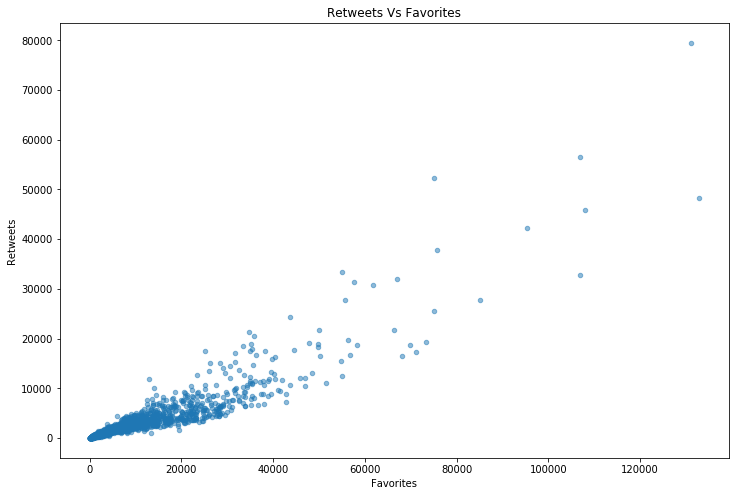

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline


wrd_df.plot(kind = 'scatter', x = 'favorite_count', y = 'retweet_count', alpha = 0.5, figsize = (12,8))
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets Vs Favorites');

As we can see from the scatter plot, there is a positive correlation between the number of favorites the tweet gets and the number of retweets.

In [73]:
# most predicted breeds

wrd_df.predicted_breed.value_counts()

golden_retriever                  158
Labrador_retriever                108
Pembroke                          95 
Chihuahua                         91 
pug                               62 
toy_poodle                        51 
chow                              48 
Samoyed                           42 
Pomeranian                        42 
malamute                          33 
French_bulldog                    31 
Chesapeake_Bay_retriever          31 
cocker_spaniel                    30 
miniature_pinscher                25 
Eskimo_dog                        22 
Staffordshire_bullterrier         21 
German_shepherd                   21 
Cardigan                          21 
beagle                            20 
Shih-Tzu                          20 
Siberian_husky                    20 
Shetland_sheepdog                 19 
Rottweiler                        19 
Maltese_dog                       19 
Lakeland_terrier                  18 
kuvasz                            18 
Italian_grey

We can see that Golden retreivers are the most common predicted breed. What if we checked how that number holds up as we vary minimum confidence levels?

In [74]:
wrd_df.loc[wrd_df.confidence_level >= 0.75].predicted_breed.value_counts()

golden_retriever                  78
Pembroke                          47
Labrador_retriever                41
pug                               34
Chihuahua                         25
Samoyed                           22
Pomeranian                        22
chow                              16
French_bulldog                    14
toy_poodle                        13
malamute                          10
German_shepherd                   9 
Maltese_dog                       8 
Shetland_sheepdog                 8 
Bernese_mountain_dog              7 
Chesapeake_Bay_retriever          7 
Brittany_spaniel                  6 
Blenheim_spaniel                  6 
miniature_pinscher                6 
beagle                            5 
cocker_spaniel                    5 
Old_English_sheepdog              5 
Doberman                          5 
dalmatian                         5 
Rottweiler                        5 
American_Staffordshire_terrier    5 
basset                            5 
G

In [75]:
wrd_df.loc[wrd_df.confidence_level >= 0.95].predicted_breed.value_counts()

pug                            20
Samoyed                        19
Pembroke                       19
golden_retriever               16
Pomeranian                     13
Chihuahua                      9 
Labrador_retriever             9 
French_bulldog                 8 
chow                           7 
German_shepherd                4 
Bernese_mountain_dog           4 
Shetland_sheepdog              4 
Blenheim_spaniel               3 
Old_English_sheepdog           3 
Pekinese                       3 
beagle                         3 
malamute                       2 
Rottweiler                     2 
vizsla                         2 
komondor                       2 
dalmatian                      2 
Boston_bull                    2 
English_springer               2 
Saint_Bernard                  2 
Shih-Tzu                       2 
keeshond                       2 
basset                         2 
cocker_spaniel                 2 
bull_mastiff                   2 
miniature_pins

In [76]:
wrd_df.stage.value_counts()

pupper     451
doggo      329
floofer    29 
puppo      29 
Name: stage, dtype: int64

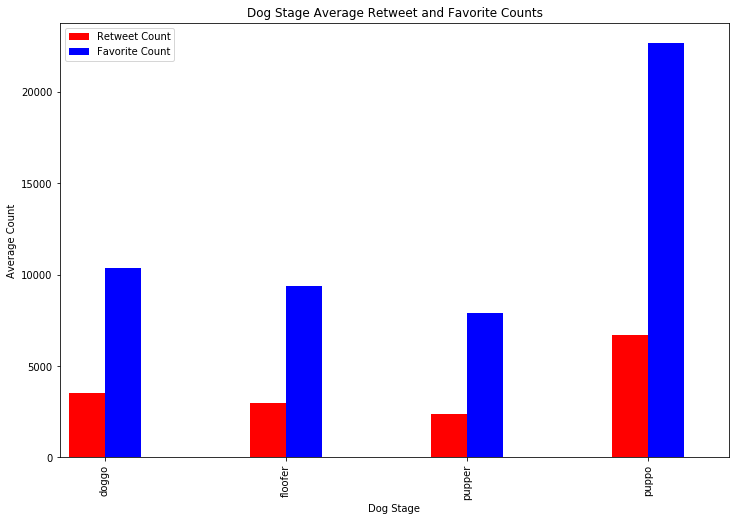

In [77]:


# fig = 
# ax = fig.add_subplot(111) # Create matplotlib axes
# ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.


plt.figure(figsize = (12,8))
width = 0.2

wrd_df.groupby('stage').retweet_count.mean().plot(kind='bar', color='red', width=width, position=1)
wrd_df.groupby('stage').favorite_count.mean().plot(kind='bar', color='blue',width=width, position=0)



plt.xlabel('Dog Stage')
plt.ylabel('Average Count')
plt.legend(['Retweet Count', 'Favorite Count'])
plt.title('Dog Stage Average Retweet and Favorite Counts')


plt.show()